In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import pickle
import ast
from tqdm import tqdm
from scipy.sparse import csr_matrix
import itertools
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
import nltk
nltk.download('punkt')
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *
from SHapRAG.utils import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df=pd.read_json("../data/musique/musique_ans_v1.0_train.jsonl", lines=True)

In [3]:
def get_titles(lst):
    # Titles where is_supporting is True
    supporting = [d['paragraph_text'] for d in lst if d.get('is_supporting') == True]
    # Titles where is_supporting is False or missing AND not already in supporting
    others = [d['paragraph_text'] for d in lst if d.get('is_supporting') != True and d['paragraph_text'] not in supporting]
    # Combine: all supporting + as many others as needed to reach 10
    result = supporting + others
    return result[:10]

df.paragraphs=df.paragraphs.apply(get_titles)

In [4]:
# df['Sentences'] = df['paragraphs'].apply(
#     lambda para_list: [sent for para in para_list for sent in nltk.sent_tokenize(para)]
# )

In [5]:
# df_save=pd.read_csv('../data/musique/sen_labeled.csv',
#     quotechar='"',
#     skipinitialspace=True,
#     engine='python' )

In [6]:
df["paragraphs"] = df["paragraphs"].apply(lambda p: p[:5]+ [p[1]] + p[5:])

In [7]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [8]:
num_questions_to_run=50
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]
extras=[]
# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1,5]

for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    # gt=ast.literal_eval(df_save.labels[i])
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs=df.paragraphs[i]
    utility_cache_base_dir = f"../Experiment_data/musique/{model_path.split('/')[1]}/duplicate"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )
    # res = evaluate(df.question[i], harness.target_response, df.answer[i])
    # if res=="True":
    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map = {"L": 364}

        # Store FM models for later R²/MSE
        fm_models = {}

        for size_key, num_s in m_samples_map.items():
            if 2 ** len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2 ** len(docs) - 1 if 2 ** len(docs) > 0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0:
                methods_results[f"ContextCite{actual_samples}"], model_cc = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )

                attributions, interactions = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                methods_results[f"FBII{actual_samples}"] = attributions['fbii']
                methods_results[f"Spex{actual_samples}"] = attributions['fourier']
                methods_results[f"FSII{actual_samples}"] = attributions['fsii']

                # methods_results[f"FM_WeightsDU{actual_samples}"], Fdu, modelfmdu = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="uniform",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsDK{actual_samples}"], Fdk, modelfmdk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                methods_results[f"FM_WeightsLK{actual_samples}"], Flk, modelfmlk = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="kernelshap", sur_type="fm"
                )
                methods_results[f"FM_WeightsLU{actual_samples}"], Flu, modelfmlu = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm"
                )

                # Save FM models
                fm_models.update({
                    # f"FM_WeightsDU{actual_samples}": modelfmdu,
                    # f"FM_WeightsDK{actual_samples}": modelfmdk,
                    f"FM_WeightsLK{actual_samples}": modelfmlk,
                    f"FM_WeightsLU{actual_samples}": modelfmlu
                })

                # Save extra Fs
                extra_results.update({
                    # "Fdu": Fdu,
                    # "Fdk": Fdk,
                    "Flk": Flk,
                    "Flu": Flu,
                    "Int_FSII":interactions['fsii'],
                    "Int_FBII":interactions['fbii'],
                    "Int_Spex":interactions['fourier']
                })

        methods_results["LOO"] = harness.compute_loo()
        methods_results["ARC-JSD"] = harness.compute_arc_jsd()

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="probability", modelk=modelfmlk, modelu=modelfmlu
        )
        metrics_results["topk_divergence"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="divergence", modelk=modelfmlk, modelu=modelfmlu
        )
        metrics_results["topk_response_probability"] = harness.top_k_response_probability(
            methods_results, k_values=[1, 2, 3]
        )

        # R² and MSE for ContextCite
        try:
            r2, mse = harness.r2_mse(30, 'logit-prob', model_cc, method='cc')
            metrics_results["R2_cc"] = r2
            metrics_results["MSE_cc"] = mse
        except Exception: continue

        # R² and MSE for each FM method that has a model
        for method_name, fm_model in fm_models.items():
            r2, mse = harness.r2_mse(30, 'logit-prob', fm_model, method='fm')
            metrics_results[f"R2_{method_name}"] = r2
            metrics_results[f"MSE_{method_name}"] = mse

        # LDS per method
        LDS = {}
        for method_name, scores in methods_results.items():
            if "FM_WeightsLU" in method_name:
                LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlu)
            if "FM_WeightsLK" in method_name:
                LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlk)
            else:
                LDS[method_name] = harness.lds(scores, 30)
        metrics_results["LDS"] = LDS

        # Precision per method
        precision_scores = {}
        gtset_k = get_gtset_k()
        for method_name, scores in methods_results.items():
            precision_scores[method_name] = harness.precision(gtset_k, scores)
        metrics_results["precision"] = precision_scores

        harness.save_utility_cache(current_utility_path)

        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": df.answer[i],
            "response": harness.target_response,
            "methods": methods_results,
            "metrics": metrics_results
        })
        extras.append(extra_results)

  0%|          | 0/50 [00:00<?, ?it/s]


--- Question 1/50: When was the institute that owned The Collegian founded?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx0.pkl...
Successfully loaded 1276 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 437582.88it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  2%|▏         | 1/50 [02:05<1:42:07, 125.06s/it]


--- Question 2/50: What year saw the creation of the region where the county of... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx1.pkl...
Successfully loaded 1354 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 587428.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  4%|▍         | 2/50 [03:42<1:26:54, 108.63s/it]

Main Process: Saving 1354 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx1.pkl...
Save complete.

--- Question 3/50: When was the abolishment of the studio that distributed The ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx2.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 443686.91it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  6%|▌         | 3/50 [04:32<1:04:19, 82.11s/it] 

Main Process: Saving 1348 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx2.pkl...
Save complete.

--- Question 4/50: When was the publisher of Crux launched?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx3.pkl...
Successfully loaded 1344 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 437457.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  8%|▊         | 4/50 [05:08<49:00, 63.93s/it]  

Main Process: Saving 1345 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx3.pkl...
Save complete.

--- Question 5/50: Jan Šindel's was born in what country?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx4.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 603687.88it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 5/50 [05:31<36:55, 49.23s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx4.pkl...
Save complete.

--- Question 6/50: What city is the person who broadened the doctrine of philos... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx5.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 575254.96it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 12%|█▏        | 6/50 [06:02<31:23, 42.81s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx5.pkl...
Save complete.

--- Question 7/50: When was the baseball team winning the world series in 2015 ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx6.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 613882.85it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 14%|█▍        | 7/50 [06:40<29:33, 41.24s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx6.pkl...
Save complete.

--- Question 8/50: Where did the Baldevins bryllup director die?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx7.pkl...
Successfully loaded 1344 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 594519.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 16%|█▌        | 8/50 [07:02<24:40, 35.26s/it]

Main Process: Saving 1344 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx7.pkl...
Save complete.

--- Question 9/50: Who was thee first president of the association that wrote t... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx8.pkl...
Successfully loaded 1350 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 568401.58it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 18%|█▊        | 9/50 [07:36<23:46, 34.80s/it]

Main Process: Saving 1350 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx8.pkl...
Save complete.

--- Question 10/50: Which major Russian city borders the body of water in which ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx9.pkl...
Successfully loaded 1350 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 585401.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 20%|██        | 10/50 [08:04<21:53, 32.83s/it]

Main Process: Saving 1350 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx9.pkl...
Save complete.

--- Question 11/50: When was the employer of John J. Collins established?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx10.pkl...
Successfully loaded 1343 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 580063.32it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 22%|██▏       | 11/50 [08:36<21:08, 32.54s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx10.pkl...
Save complete.

--- Question 12/50: When did Bush declare the war causing Kerry to criticize him... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx11.pkl...
Successfully loaded 1350 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 591983.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 24%|██▍       | 12/50 [09:22<23:04, 36.44s/it]

Main Process: Saving 1350 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx11.pkl...
Save complete.

--- Question 13/50: What is the college Francis Walsingham attended an instance ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx12.pkl...
Successfully loaded 1354 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 608015.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 26%|██▌       | 13/50 [09:45<20:02, 32.51s/it]

Main Process: Saving 1354 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx12.pkl...
Save complete.

--- Question 14/50: What type of university is the college Kyeon Mi-ri attended?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx13.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 584057.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 28%|██▊       | 14/50 [10:07<17:29, 29.16s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx13.pkl...
Save complete.

--- Question 15/50: In what year was the author of The Insider's Guide to the Co... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx14.pkl...
Successfully loaded 1342 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 602021.55it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 30%|███       | 15/50 [10:38<17:25, 29.88s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx14.pkl...
Save complete.

--- Question 16/50: When was the territory covered by RIBA's Cambridge branch of... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx15.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 580504.43it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 32%|███▏      | 16/50 [11:01<15:40, 27.65s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx15.pkl...
Save complete.

--- Question 17/50: What's the meaning of the name of the school that does not i... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx16.pkl...
Successfully loaded 1350 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 576340.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 34%|███▍      | 17/50 [11:43<17:39, 32.12s/it]

Main Process: Saving 1350 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx16.pkl...
Save complete.

--- Question 18/50: Where did the director who provided the lyrics to A Time for... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx17.pkl...
Successfully loaded 1342 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 508569.84it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 36%|███▌      | 18/50 [12:24<18:33, 34.79s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx17.pkl...
Save complete.

--- Question 19/50: When did the country formerly known as Zaire become independ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx18.pkl...
Successfully loaded 1352 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 597310.90it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 38%|███▊      | 19/50 [13:03<18:36, 36.00s/it]

Main Process: Saving 1352 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx18.pkl...
Save complete.

--- Question 20/50: Where did Peter and Paul Fortress' designer die?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx19.pkl...
Successfully loaded 1343 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 582942.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 40%|████      | 20/50 [13:37<17:40, 35.33s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx19.pkl...
Save complete.

--- Question 21/50: When did the network which airs Alt for Norge start?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx20.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 590609.92it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 42%|████▏     | 21/50 [14:01<15:29, 32.06s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx20.pkl...
Save complete.

--- Question 22/50: Who failed to take back what the French believed instrumenta... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx21.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 575471.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 44%|████▍     | 22/50 [14:36<15:18, 32.79s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx21.pkl...
Save complete.

--- Question 23/50: What is the field of work of the proposer of the modern synt... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx22.pkl...
Successfully loaded 1351 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 458063.80it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 46%|████▌     | 23/50 [15:43<19:24, 43.14s/it]

Main Process: Saving 1351 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx22.pkl...
Save complete.

--- Question 24/50: When was the season of Greys Anatomy when Derek died filmed?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx23.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 371647.19it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 48%|████▊     | 24/50 [17:02<23:19, 53.83s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx23.pkl...
Save complete.

--- Question 25/50: When did the manufacturer of a pedometer accessory for the i... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx24.pkl...
Successfully loaded 1275 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 425627.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|█████     | 25/50 [18:24<26:00, 62.41s/it]

Main Process: Saving 1346 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx24.pkl...
Save complete.

--- Question 26/50: What is the record label for the person who sang Beauty and ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx25.pkl...
Successfully loaded 1273 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 435958.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 52%|█████▏    | 26/50 [21:00<36:13, 90.58s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx25.pkl...
Save complete.

--- Question 27/50: Who is the employer of the Iranian scientist who co-invented... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx26.pkl...
Successfully loaded 1271 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 439978.86it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 54%|█████▍    | 27/50 [22:27<34:13, 89.27s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx26.pkl...
Save complete.

--- Question 28/50: How many championships in a row were won by the person who p... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx27.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 427056.41it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 56%|█████▌    | 28/50 [23:49<31:58, 87.21s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx27.pkl...
Save complete.

--- Question 29/50: In what language is the star of Koyelaanchal fluent?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx28.pkl...
Successfully loaded 1351 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 573741.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 58%|█████▊    | 29/50 [24:36<26:14, 75.00s/it]

Main Process: Saving 1351 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx28.pkl...
Save complete.

--- Question 30/50: What instrument did the artiste for Vi skall fara bortom mån... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx29.pkl...
Successfully loaded 1270 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 577430.66it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 60%|██████    | 30/50 [25:37<23:39, 70.96s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx29.pkl...
Save complete.

--- Question 31/50: What year did the council which was seated in 1949 adopt the... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx30.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 418969.99it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 62%|██████▏   | 31/50 [27:10<24:35, 77.68s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx30.pkl...
Save complete.

--- Question 32/50: When did the author of season 7 of game of thrones begin wri... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx31.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 593133.90it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 64%|██████▍   | 32/50 [27:53<20:09, 67.19s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx31.pkl...
Save complete.

--- Question 33/50: What languages are spoken, written or signed by the person t... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx32.pkl...
Successfully loaded 1275 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 566713.68it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 66%|██████▌   | 33/50 [29:11<19:54, 70.27s/it]

Main Process: Saving 1345 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx32.pkl...
Save complete.

--- Question 34/50: What language did the leader of the least radicalized factio... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx33.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 595215.07it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 68%|██████▊   | 34/50 [29:45<15:52, 59.55s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx33.pkl...
Save complete.

--- Question 35/50: When did the majority of the patents held by the company the... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx34.pkl...
Successfully loaded 1268 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 573526.17it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 70%|███████   | 35/50 [30:41<14:34, 58.30s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx34.pkl...
Save complete.

--- Question 36/50: What language is used by the person after whom the Panizzi l... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx35.pkl...
Successfully loaded 1348 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 587202.56it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 72%|███████▏  | 36/50 [31:09<11:29, 49.27s/it]

Main Process: Saving 1348 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx35.pkl...
Save complete.

--- Question 37/50: What is the language for the person who translated Plato's w... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx36.pkl...
Successfully loaded 1276 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 584057.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 74%|███████▍  | 37/50 [32:12<11:33, 53.32s/it]

Main Process: Saving 1345 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx36.pkl...
Save complete.

--- Question 38/50: What did Goring believe the person whom he refused to work w... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx37.pkl...
Successfully loaded 1270 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 592673.39it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 76%|███████▌  | 38/50 [33:28<12:01, 60.14s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx37.pkl...
Save complete.

--- Question 39/50: Who was the president of the body that petitioned the king o... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx38.pkl...
Successfully loaded 1271 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 578963.46it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 78%|███████▊  | 39/50 [34:38<11:35, 63.26s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx38.pkl...
Save complete.

--- Question 40/50: What city is the place Kara Vâsıf Bey died located in?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx39.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 598012.79it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 80%|████████  | 40/50 [35:02<08:33, 51.36s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx39.pkl...
Save complete.

--- Question 41/50: What languages can the star of Accident on Hill Road speak, ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx40.pkl...
Successfully loaded 1271 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 555173.33it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 82%|████████▏ | 41/50 [36:04<08:11, 54.57s/it]

Main Process: Saving 1342 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx40.pkl...
Save complete.

--- Question 42/50: In what year did France host the finals of the competition f... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx41.pkl...
Successfully loaded 1273 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 597544.68it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 84%|████████▍ | 42/50 [37:23<08:16, 62.02s/it]

Main Process: Saving 1344 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx41.pkl...
Save complete.

--- Question 43/50: In which year did the publisher of Roald Dahl's Guide to Rai... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx42.pkl...
Successfully loaded 1350 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 605603.59it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 86%|████████▌ | 43/50 [37:46<05:51, 50.25s/it]

Main Process: Saving 1350 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx42.pkl...
Save complete.

--- Question 44/50: When was the inception of the company that released Poptropi... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx43.pkl...
Successfully loaded 1349 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 585850.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 88%|████████▊ | 44/50 [38:09<04:12, 42.05s/it]

Main Process: Saving 1349 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx43.pkl...
Save complete.

--- Question 45/50: When did the distributer of Poptropica start?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx44.pkl...
Successfully loaded 1272 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 593595.12it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 90%|█████████ | 45/50 [38:59<03:42, 44.55s/it]

Main Process: Saving 1343 utility entries to ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx44.pkl...
Save complete.

--- Question 46/50: What is the source of the river where Southern California ge... ---
Main Process: Attempting to load utility cache from ../Experiment_data/musique/Llama-3.1-8B-Instruct/duplicate/utilities_q_idx45.pkl...
Successfully loaded 1274 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 580725.24it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 90%|█████████ | 45/50 [39:28<04:23, 52.63s/it]


KeyboardInterrupt: 

In [9]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 3, 5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        "cc": "ContextCite364"  # rename cc to full name
    }

    for res in all_results:
        metrics = res["metrics"]

        # R² / MSE
        for key, val in metrics.items():
            if key.startswith("R2_") or key.startswith("MSE_"):
                raw_method = key.split("_", 1)[1]
                method = method_name_map.get(raw_method, raw_method)  # rename if needed
                metric_name = key.split("_", 1)[0]  # "R2" or "MSE"
                table_data[method][metric_name].append(val)

        # LDS
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        # # Precision
        for method_name, prec_val in metrics["precision"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["precision"].append(prec_val)

        # # Top-k
        for metric_type in ["topk_probability", "topk_divergence", "topk_response_probability"]:
            for method_name, k_dict in metrics[metric_type].items():
                method = method_name_map.get(method_name, method_name)
                for k in k_values:
                    if k in k_dict:
                        col_name = f"{metric_type}_k{k}"
                        table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


In [10]:
df_res=summarize_and_print(all_results, k_values=[1, 2, 3])


=== Metrics Summary Across All Queries ===
                    R2    MSE    LDS  precision  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_divergence_k1  topk_divergence_k2  topk_divergence_k3  topk_response_probability_k1  topk_response_probability_k2  topk_response_probability_k3
ARC-JSD            NaN    NaN 0.6620     0.6515               9.6614               9.7879              12.8725              1.1514              1.1904              1.4667                        0.1648                        0.2796                        0.3834
ContextCite364  0.6659 5.7337 0.7383     0.8182               9.6225              13.0104              17.4036              1.1100              1.4307              1.8403                        0.1959                        0.3152                        0.3807
FBII364            NaN    NaN 0.5461     0.7955               7.9177              13.1148              17.8028              0.9752              1.4771              1.9145   

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def compute_recall_at_k(all_results, k_values=[1,2, 3,4, 5]):
    methods = list(df_res.index)
    recall_table = {m: [] for m in methods}

    for k in k_values:
        for method in methods:
            recalls = []
            for p, res in enumerate(all_results):
                gt_indices = set([0,1,5])
                # gt_indices = set(ast.literal_eval(df_save.labels[p]))
                scores = np.array(res["methods"][method])
                topk_indices = set(scores.argsort()[-k:])
                hits = len(gt_indices & topk_indices)
                recalls.append(hits / len(gt_indices) if gt_indices else np.nan)
            recall_table[method].append(np.nanmean(recalls))
    return recall_table


def plot_recall_at_k(recall_table, k_values=[1,2, 3,4, 5]):
    plt.figure(figsize=(8, 5))
    for method, recalls in recall_table.items():
        plt.plot(k_values, recalls, marker="o", label=method)
    plt.xlabel("k")
    plt.ylabel("Recall@k")
    plt.title("Recall@k for All Methods")
    plt.xticks(k_values)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


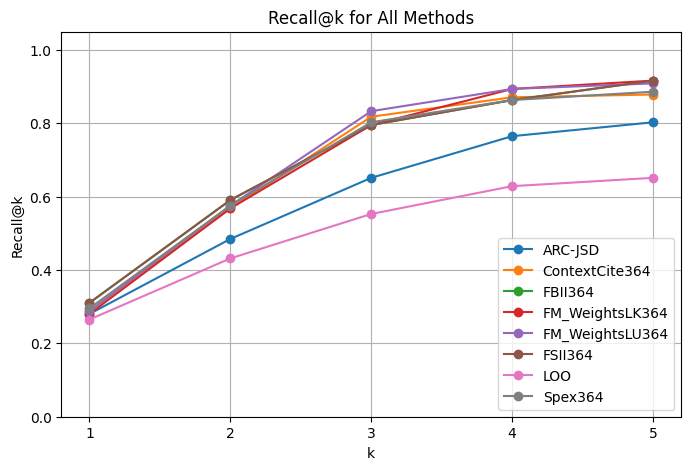

In [12]:
recall_table=compute_recall_at_k(all_results, k_values=[1, 2, 3, 4, 5])
plot_recall_at_k(recall_table, k_values=[1, 2, 3, 4, 5])

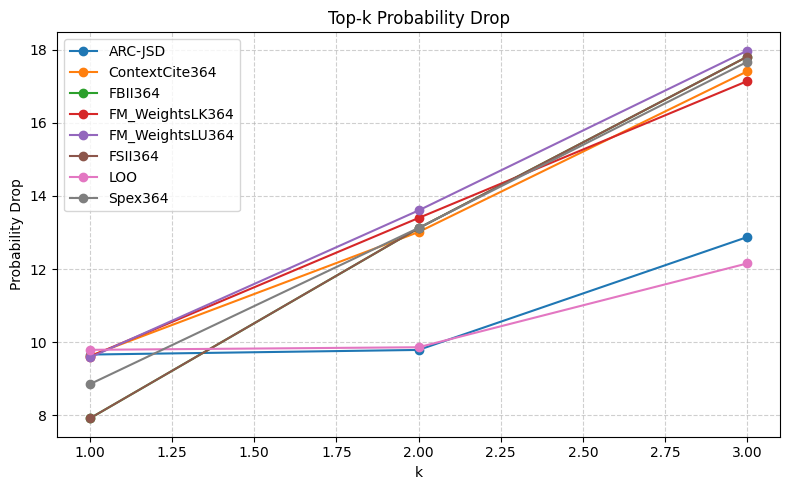

In [13]:
plt.figure(figsize=(8, 5))
for method in df_res.index:
    plt.plot(
        [1, 2, 3],
        df_res.loc[method, ['topk_probability_k1', 'topk_probability_k2', 'topk_probability_k3']],
        marker='o',
        label=method
    )

plt.xlabel('k')
plt.ylabel('Probability Drop')
plt.title('Top-k Probability Drop')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
all_results[12]

In [ ]:
all_results[2]['extra']['Flu'][0].argmax()

In [ ]:
all_results[2]['extra']['Flu'][1].argmin()

In [ ]:
extras[1]['Flu'].argmin()

In [ ]:
import numpy as np

def evaluate_methods(extras, k, m, interaction_type="max"):

    methods = ["Flu", "Int_FSII", "Int_FBII", "Int_Spex"]
    scores = {m: 0 for m in methods}
    n_experiments = len(extras)

    for exp in extras:
        for method in methods:
            if method == "Flu":
                # Flu is a matrix
                value = exp["Flu"][k][m]
                all_values = exp["Flu"].flatten()
            else:
                # Dictionaries with tuple keys
                d = exp[method]
                value = None
                for key, v in d.items():
                    ones = [i for i, bit in enumerate(key) if bit == 1]
                    if set(ones) == {k, m}:
                        value = v
                        break
                if value is None:
                    continue  # skip if (k,m) not found
                all_values = list(d.values())

            if interaction_type == "max":
                if value == max(all_values):
                    scores[method] += 1
            elif interaction_type == "min":
                if value == min(all_values):
                    scores[method] += 1

    # Convert to fraction of experiments
    results = {method: scores[method] / n_experiments for method in methods}
    return results


In [ ]:
evaluate_methods(extras, k=1, m=5, interaction_type="min")

In [ ]:
all_results[5]